## A simple model for demand and supply of geolocalized services in a city

### Load libraries and classes

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import os
import sys
nb_dir = os.path.dirname(os.getcwd()) ## TODO: find way to put this into some global settings
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import common_cfg, istat_kpi, city_settings

In [2]:
from src.models.city_items import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model
from src.models.core import ServiceUnit, ServiceValues, ServiceEvaluator, \
    MappedPositionsFrame, DemandFrame, KPICalculator
from src.models.factories import UnitFactory
from src.models.process_tools import GridMaker, ValuesPlotter, JSONWriter

In [3]:
selected_city = 'Milano'

### Load service data: locations, scales, other info for city

In [4]:
loaders = UnitFactory.make_loaders_for_city(
    city_settings.get_city_config(selected_city))

print(loaders)

# Initialise with a default lengthscale of 0.4 km
school_units = loaders['Scuole'].load(
    mean_radius=0.4, size_power_law=0.4, private_rescaling=1)

# Initialise with a default lengthscale of 0.5 km
pharmacy_units = loaders['Farmacie'].load(mean_radius=0.5)

# Initialise with a default lengthscale of 0.3 km

## awful hack to quickly clean tpl file #FIXME
loaders['Fermate TPL']._raw_data = loaders['Fermate TPL']._raw_data[
    loaders['Fermate TPL']._raw_data['route_type'].isin([0,1,3])].reset_index()

tpl_units = loaders['Fermate TPL'].load(mean_radius=0.3)

# Initialise with a default lengthscale of 0.4 km
library_units = loaders['Biblioteche'].load(mean_radius=0.4)


{'Biblioteche': <src.models.factories.LibraryFactory object at 0x7f7ad9cb57f0>, 'Fermate TPL': <src.models.factories.TransportStopFactory object at 0x7f7ad9d386d8>, 'Scuole': <src.models.factories.SchoolFactory object at 0x7f7ad9d38358>, 'Farmacie': <src.models.factories.PharmacyFactory object at 0x7f7ad9d38668>}
Location data found
ServiceType.School -- dropping 1 units outside city.
Observed mean capacity 278.25 for SCUOLA PRIMARIA
Observed mean capacity 297.94 for SCUOLA SECONDARIA I GRADO
Location data found
ServiceType.Pharmacy -- dropping 71 units outside city.
Location data found
Location data found
ServiceType.Library -- dropping 95 units outside city.


### Demand import from Censimento Popolazione e Abitazioni (CPA) 2011

In [5]:
demand_data = DemandFrame.create_from_istat_cpa(selected_city)

### Define the demand frame and the units to use by building the KPI calculator

In [6]:
b_demo = False

if b_demo:
    # demo mode, use a portion of the data
    demand_test = DemandFrame(demand_data.sample(50, random_state=80).copy(), False)
    test_units = school_units[::50] + pharmacy_units[::30] + tpl_units[::30] 
    calculator = KPICalculator(demand_test, test_units, selected_city)
else:
    #calculator = KPICalculator(
    #    demand_data, school_units + pharmacy_units + tpl_units + library_units, 
    #    selected_city)
    # schools only computation:
    calculator = KPICalculator(demand_data, school_units, selected_city)

### Evaluate the services offer at the demand points and average over neighbourhood

Ignoring interactions below 0.0001 

ServiceType.School Approx distance matrix in 0.0281

 Computing ServiceType.School AgeGroup.ChildPrimary
AgeGroup time 3.9187

 Computing ServiceType.School AgeGroup.ChildMid
AgeGroup time 1.9267
ServiceType.School: AgeGroup.ChildMid -- unassigned: 113 | Total: 48987
ServiceType.School: AgeGroup.ChildPrimary -- unassigned: 33 | Total: 53328

 Using available capacity for service Scuole


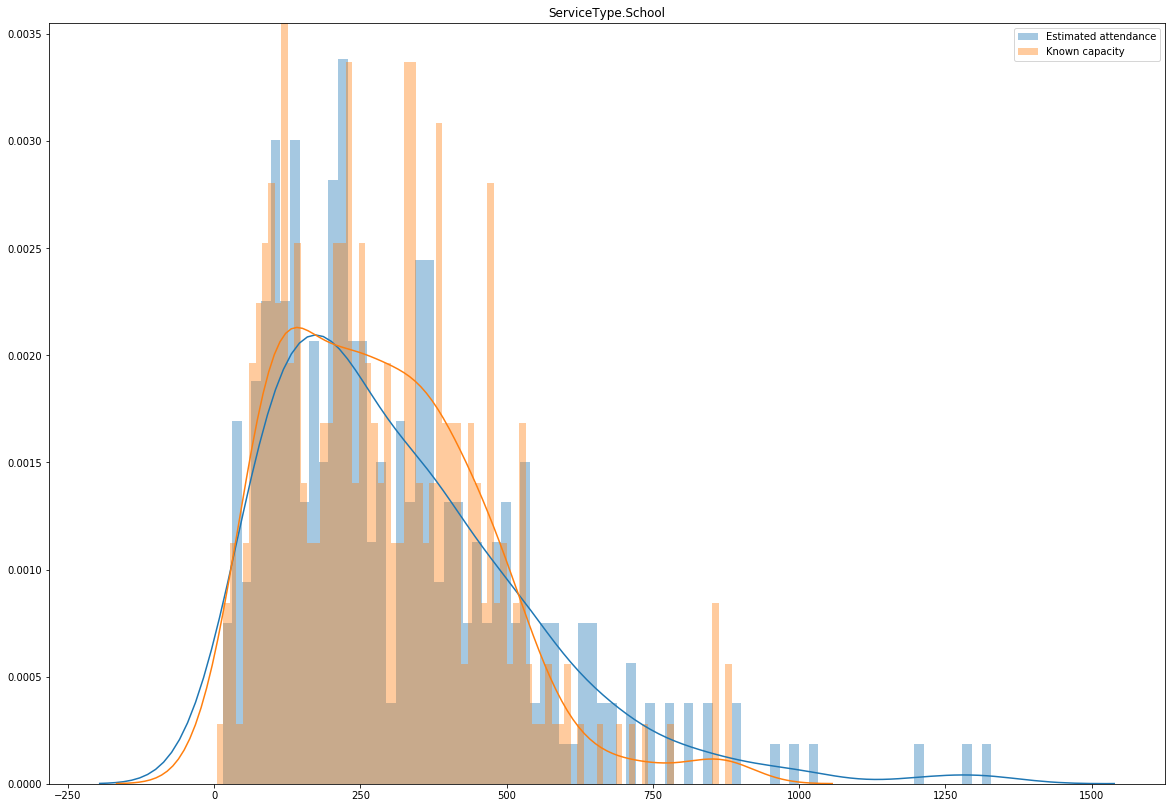

In [7]:
# print current value of kernel cutoff
print('Ignoring interactions below %s \n' % common_cfg.kernel_value_cutoff)

# compute and plot demand/supply interaction for localized services 
calculator.evaluate_services_at_demand(b_evaluate_attendance=True, clip_level=1.4)  # this might take a while.

for _,loader in loaders.items():
    pass
    loader.save_units_with_attendance_to_geojson(calculator.evaluator.units)
    
calculator.plot_attendance_distributions()

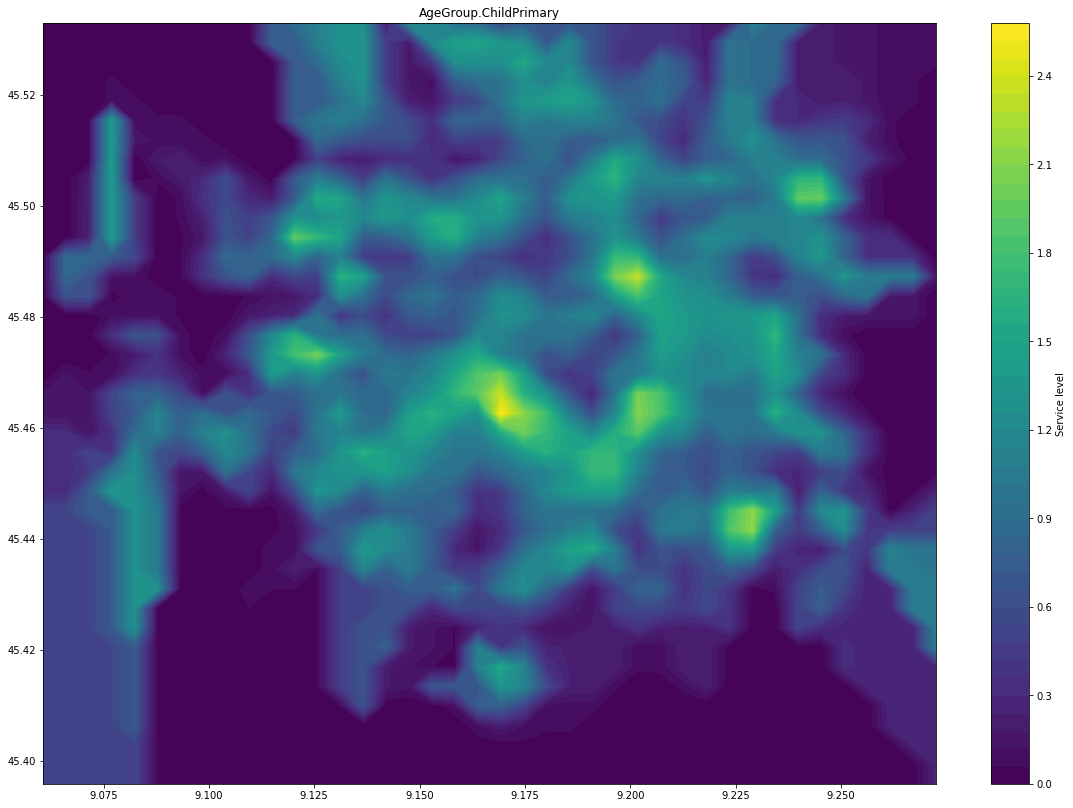

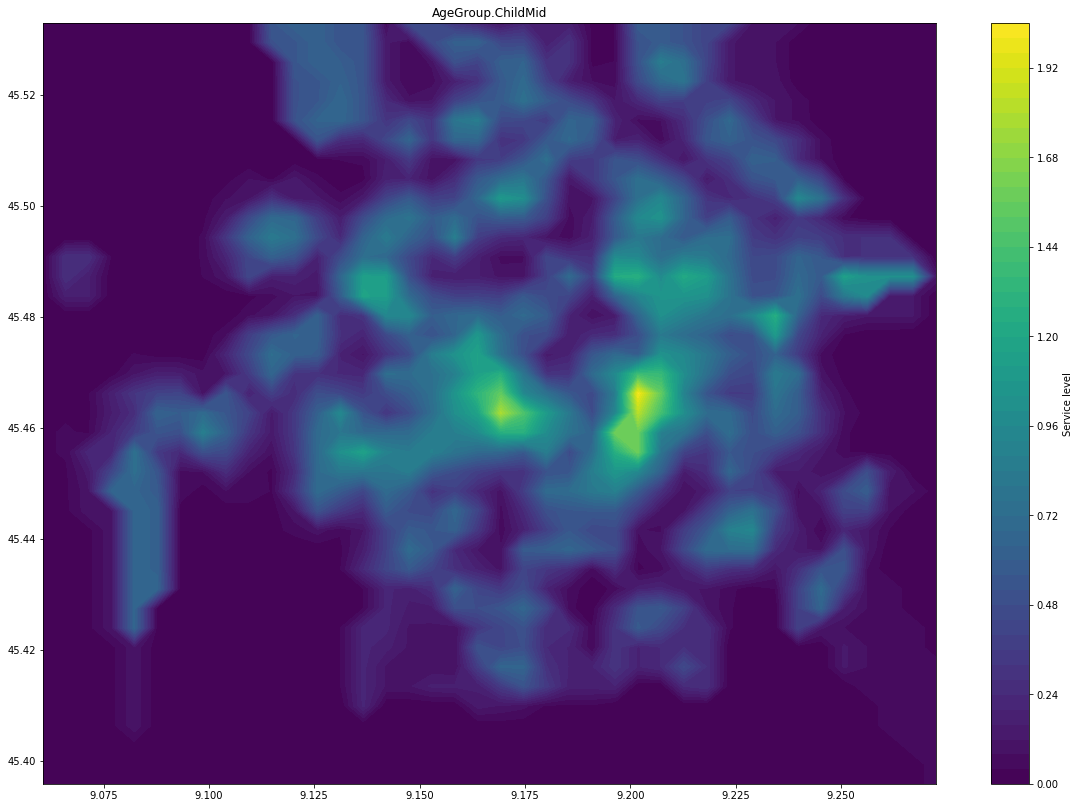

In [8]:
heat_map_plotter = ValuesPlotter(calculator.service_values)
heat_map_plotter.plot_service_levels(ServiceType.School)

### Aggregate into neighbourhood KPI and export values by Neighbourhood-Service-AgeGroup to JSON

In [9]:
calculator.compute_kpi_for_localized_services()
calculator.compute_kpi_for_istat_values()

# write KPI to json outputb
json_maker = JSONWriter(calculator)
json_maker.write_all_files_to_default_path()